# Кредитный скоринг

In [194]:
#Загрузка библиотек и скриптов
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import random

import scipy
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

# Путь к данным
train_path = '/home/polmura/GeekBrains/Python_libs_2/course_project/course_project_train.csv'
test_path = '/home/polmura/GeekBrains/Python_libs_2/course_project/course_project_test.csv'
TEST_PART_PATH = '/home/polmura/GeekBrains/Python_libs_2/course_project/test_preds.csv'

# Загрузка датасета
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [195]:
# Устранение выбросов

In [196]:
df_train['Annual Income'].quantile(.99)

df_train.loc[df_train['Annual Income'] > 4000000, 'Annual Income'] = 4000000
df_test.loc[df_test['Annual Income'] > 4000000, 'Annual Income'] = 4000000

df_train.loc[df_train['Number of Open Accounts'] > 20, 'Number of Open Accounts'] = 20
df_test.loc[df_test['Number of Open Accounts'] > 20, 'Number of Open Accounts'] = 20

df_train.loc[df_train['Years of Credit History'] > 30, 'Years of Credit History'] = 30
df_test.loc[df_test['Years of Credit History'] > 30, 'Years of Credit History'] = 30

# Нулевые значения
q_25 = df_train['Maximum Open Credit'].quantile(.25)
q_75 = df_train['Maximum Open Credit'].quantile(.75)

df_train.loc[df_train['Maximum Open Credit'] == 0, 'Maximum Open Credit'] =\
[round(random.uniform(q_25, q_75), 2) for x in range(df_train[df_train['Maximum Open Credit'] == 0].shape[0])]

df_test.loc[df_test['Maximum Open Credit'] == 0, 'Maximum Open Credit'] =\
[round(random.uniform(q_25, q_75), 2) for x in range(df_test[df_test['Maximum Open Credit'] == 0].shape[0])]

# Слишком большие значения
df_train.loc[df_train['Maximum Open Credit'] > 5000000, 'Maximum Open Credit'] = 5000000
df_test.loc[df_test['Maximum Open Credit'] > 5000000, 'Maximum Open Credit'] = 5000000

df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 1000000
df_test.loc[df_test['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 1000000

df_train['Credit Score Bin'] = 0
df_train.loc[(df_train['Credit Score'] <= 670) | (df_train['Credit Score'] >= 1000), 'Credit Score Bin'] = 1

df_test['Credit Score Bin'] = 0
df_test.loc[(df_test['Credit Score'] <= 670) | (df_test['Credit Score'] >= 1000), 'Credit Score Bin'] = 1

In [197]:
#Заполнение пропусков
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()
df_train.loc[df_train['Years in current job'].isnull(), 
             'Years in current job'] = '10+ years'
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test['Annual Income'].median()
df_test.loc[df_test['Years in current job'].isnull(), 
             'Years in current job'] = '10+ years'

In [198]:
# Создание новых переменных

In [199]:
df_train['Delta']=df_train['Annual Income']-(df_train['Monthly Debt']*12)
df_test['Delta']=df_test['Annual Income']-(df_test['Monthly Debt']*12)

**Определение признаков**

In [200]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Tax Liens', 'Number of Credit Problems', 'Delta', 'Credit Score']
TARGET_NAME = 'Credit Default'
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Credit Score Bin']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES 
LOGNORM_FEATS = ['Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Delta', 'Credit Score']

**Нормализация распределения количественных переменных**

In [201]:
pt = PowerTransformer(method='yeo-johnson')
df_train[LOGNORM_FEATS] = pt.fit_transform(df_train[LOGNORM_FEATS])
df_test[LOGNORM_FEATS] = pt.fit_transform(df_test[LOGNORM_FEATS])

Text(0.5, 1.0, 'Delta grouped by target variable')

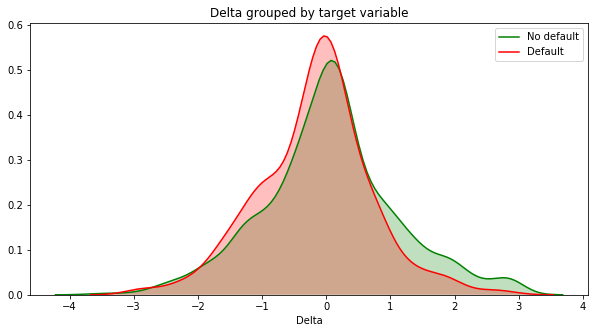

In [202]:
#Результаты нормализации
limit_bal_with_target_s = df_train[['Delta', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Delta']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Delta')
plt.title('Delta grouped by target variable')

**Приведение номинативных признаков**

In [203]:
df_train['Home Ownership'] = df_train['Home Ownership'].replace({'Home Mortgage':0, 'Rent':1, 'Own Home':2, 'Have Mortgage':3})
df_train['Years in current job'] = df_train['Years in current job'].replace({'10+ years':0, '2 years':1, 
            '3 years':2, '< 1 year':3, '5 years':4, '1 year':5, '4 years':6, '6 years':7, 
            '7 years':8, '8 years':9, '9 years':10})
df_train['Term'] = df_train['Term'].replace({'Short Term':0, 'Long Term':1})
df_train['Purpose'] = df_train['Purpose'].replace({'debt consolidation':0, 'other':1, 
            'home improvements':2, 'business loan':3, 'medical bills':4, 'major purchase':5, 'take a trip':6, 
            'buy house':7, 'small business':8, 'wedding':9, 'moving':10, 'educational expenses':11, 
                                                   'vacation':12, 'renewable energy':13, 'buy a car':14})


df_train['ID'] = df_train.index.tolist()

In [204]:
# Номинативные переменные
df_test['Home Ownership'] = df_test['Home Ownership'].replace({'Home Mortgage':0, 'Rent':1, 'Own Home':2, 'Have Mortgage':3})
df_test['Years in current job'] = df_test['Years in current job'].replace({'10+ years':0, '2 years':1, 
            '3 years':2, '< 1 year':3, '5 years':4, '1 year':5, '4 years':6, '6 years':7, 
            '7 years':8, '8 years':9, '9 years':10})
df_test['Term'] = df_test['Term'].replace({'Short Term':0, 'Long Term':1})
df_test['Purpose'] = df_test['Purpose'].replace({'debt consolidation':0, 'other':1, 
            'home improvements':2, 'business loan':3, 'medical bills':4, 'major purchase':5, 'take a trip':6, 
            'buy house':7, 'small business':8, 'wedding':9, 'moving':10, 'educational expenses':11, 
                                                   'vacation':12, 'renewable energy':13, 'buy a car':14})

# Приведение индекса
df_test['ID'] = df_test.index.tolist()

# Анализ признакового пространства

**Матрица корреляций**

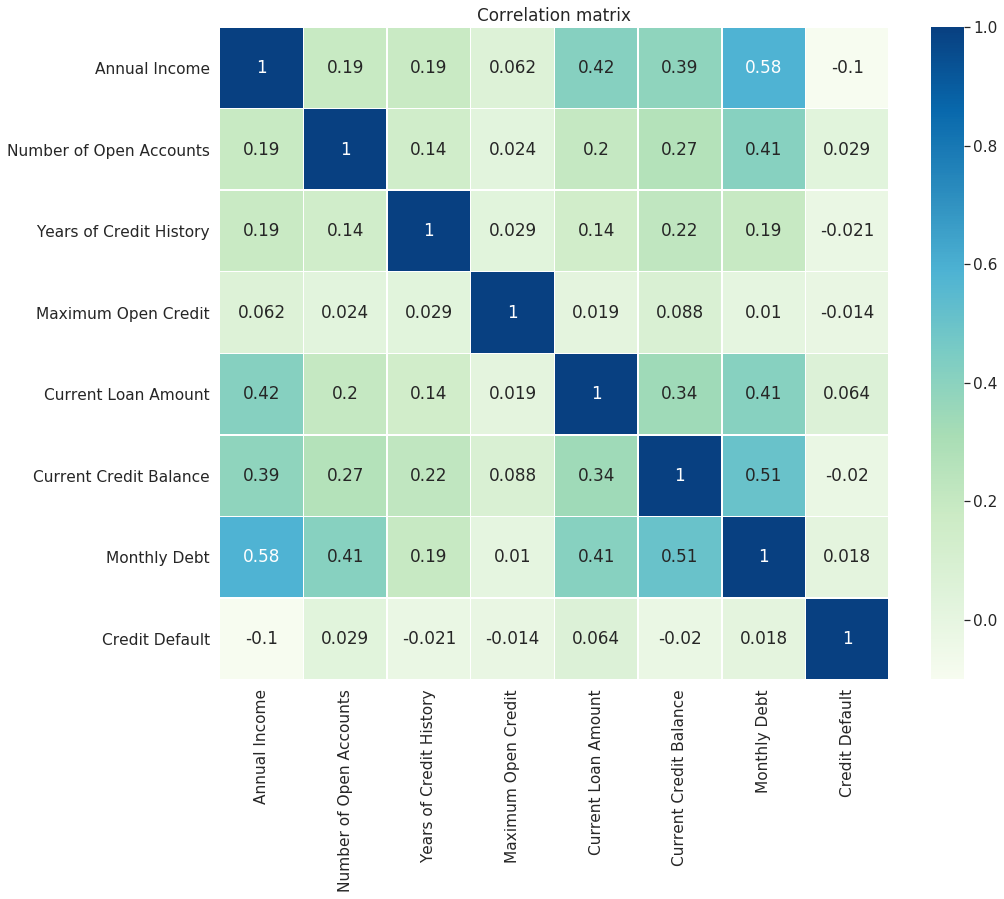

In [102]:
plt.figure(figsize = (15,12))

sns.set(font_scale=1.4)
sns.heatmap(df_train[NEW_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

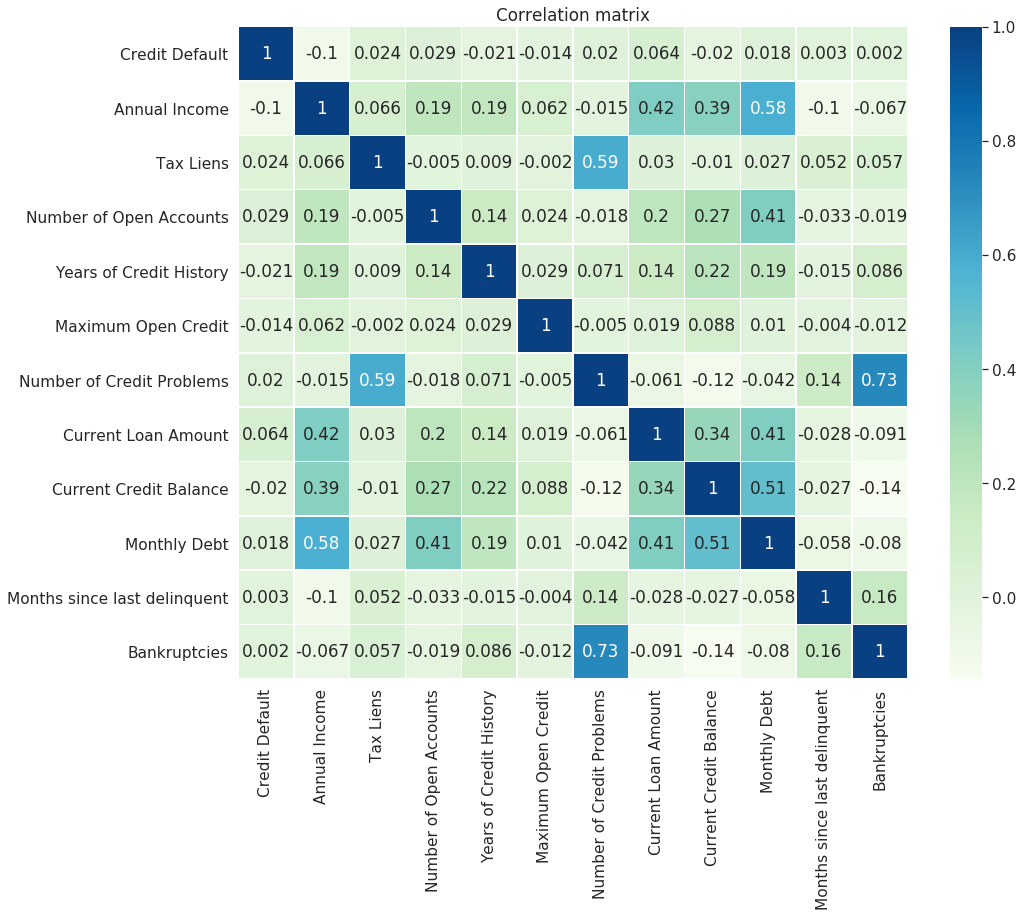

In [103]:
plt.figure(figsize = (15,12))

sns.set(font_scale=1.4)
sns.heatmap(df_train[FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# Упаковка данных

**Нормализация**

In [205]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

X = df_norm[SELECTED_FEATURE_NAMES]
y = df_norm[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

df_balanced[TARGET_NAME].value_counts()

X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

df_for_balancing_test = pd.concat([X_test, y_test], axis=1)
df_balanced_test = balance_df_by_target(df_for_balancing_test, TARGET_NAME)

df_balanced_test[TARGET_NAME].value_counts()

X_test = df_balanced_test.drop(columns=TARGET_NAME)
y_test = df_balanced_test[TARGET_NAME]

# Построение и оценка базовых моделей

In [206]:
model_lgbm = lgbm.LGBMClassifier(n_estimators = 300, max_depth = 2, random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)
y_test_pred_probs = model_lgbm.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      3771
           1       0.78      0.62      0.69      2958

   micro avg       0.76      0.76      0.76      6729
   macro avg       0.76      0.74      0.75      6729
weighted avg       0.76      0.76      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1616
           1       0.70      0.52      0.59      1268

   micro avg       0.69      0.69      0.69      2884
   macro avg       0.69      0.67      0.67      2884
weighted avg       0.69      0.69      0.68      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1336  280
1                614  654


In [207]:
y_test_pred_probs

array([[6.56121342e-01, 3.43878658e-01],
       [4.60953303e-01, 5.39046697e-01],
       [5.08332569e-01, 4.91667431e-01],
       ...,
       [9.99041652e-01, 9.58348446e-04],
       [8.55586895e-01, 1.44413105e-01],
       [5.99597161e-01, 4.00402839e-01]])

**Смещение баланса в сторону Recall**

In [208]:
y_p = np.array(y_test_pred_probs[:,1]>0.45).astype('int')
get_classification_report(y_train, y_train_pred, y_test, y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      3771
           1       0.78      0.62      0.69      2958

   micro avg       0.76      0.76      0.76      6729
   macro avg       0.76      0.74      0.75      6729
weighted avg       0.76      0.76      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1616
           1       0.64      0.61      0.62      1268

   micro avg       0.68      0.68      0.68      2884
   macro avg       0.67      0.67      0.67      2884
weighted avg       0.68      0.68      0.68      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1188  428
1                498  770


#  Приведение тестовой выборки

In [209]:
# Нормализация количественных переменных
scaler = StandardScaler()

df_norm = df_test.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

X = df_norm[SELECTED_FEATURE_NAMES]

# Отработка тестовых данных

In [210]:
y_test_preds = model_lgbm.predict(X)
y_test_pred_probs = model_lgbm.predict_proba(X)

In [211]:
y_test_pred_probs

array([[5.69502923e-01, 4.30497077e-01],
       [3.40076309e-01, 6.59923691e-01],
       [2.31383865e-03, 9.97686161e-01],
       ...,
       [4.92644966e-01, 5.07355034e-01],
       [5.67092271e-01, 4.32907729e-01],
       [9.82155388e-04, 9.99017845e-01]])

In [212]:
# Смещаем баланс в сторону recall
y_p = np.array(y_test_pred_probs[:,1]>0.45).astype('int')

In [213]:
result = pd.DataFrame(y_p)

In [214]:
result['ID'] = df_test['ID']

In [215]:
result = result.rename(columns={0: 'Credit Default'})

In [216]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
Credit Default    2500 non-null int64
ID                2500 non-null int64
dtypes: int64(2)
memory usage: 39.1 KB


In [217]:
result.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')